# Basic exploratory data analysis on NFHS-3

This notebook cleans up `household_truncated.csv` (just as is on `data.world`) and makes some initial exploratory plots.  The code could probably be reviewed and improved.  

Explanation for NFHS-3 and the project is on the [team GitHub project page](https://github.com/Data4Democracy/india-nfhs).

Codebook for variables is available in this folder at `IAHR52FL.txt`.

## Table of contents:

- **Reading in file, removing NAs**

- **Male versus female household head (`HV219`), first pass:** sex of HH head varies with HH 'relationship structure'

- **`HV219` versus other variables, programmatically:** looking for patterns

- **Three main takeaways:** besides HH structure, sex of HH head varies significantly by size of HH, age of HH head, and rural/urban status

# Reading in file, removing NAs

In [25]:
import pandas as pd
import numpy as np
from pandas import Series, DataFrame

%matplotlib inline
import matplotlib.pyplot as plt

# use low_memory = False so that it reads the dtypes correctly
df = pd.read_csv('household_truncated.csv', na_values='NaN', low_memory=False)

In [26]:
# original shape of df
df.shape

(109041, 198)

In [27]:
# sample of column names; see IAHR52FL.txt for corresponding survey questions
df.columns

Index(['HHID', 'HV000', 'HV001', 'HV002', 'HV003', 'HV004', 'HV005', 'HV006',
       'HV007', 'HV008',
       ...
       'SH65D', 'SH65E', 'SH65F', 'SH65X', 'SH66', 'SHSLI', 'SHNFHS2',
       'SHSTRUC', 'HVHIVWT', 'HVHIVWTS'],
      dtype='object', length=198)

### Missing values

In [28]:
# count NAs in each column
df.isnull().sum()

HHID             0
HV000            0
HV001            0
HV002            0
HV003            0
HV004       109041
HV005            0
HV006            0
HV007            0
HV008            0
HV009            0
HV010            0
HV011            0
HV012            0
HV013            0
HV014            0
HV015            0
HV016            0
HV017            0
HV018            0
HV019            0
HV020            0
HV021       109041
HV022            0
HV023            0
HV024            0
HV025            0
HV026            0
HV027            0
HV028        40185
             ...  
SH58ED      104574
SH58EE      104573
SH58EF      104574
SH58EG      104575
SH58EH      104574
SH58EI      104575
SH60         65149
SH61         65149
SH60H        65149
SH61H        65149
SH62A           31
SH62B           41
SH62C           48
SH62D           39
SH62E           64
SH62F           58
SH64            38
SH65A       102269
SH65B       102269
SH65C       102269
SH65D       102269
SH65E       

In [29]:
# count how many columns have more than 50k NAs
df.isnull().sum()[df.isnull().sum() > 50000].size

71

So 71 columns have more than 50,000 NAs.

In [30]:
# count how many columns have more than 10k NAs
df.isnull().sum()[df.isnull().sum() > 10000].size

81

And 81 columns have more than 10,000 NAs.

In [31]:
# look at columns with more than 10k NAs
df.columns[df.isnull().sum() > 10000]

Index(['HV004', 'HV021', 'HV028', 'HV033', 'HV043', 'HV225', 'HV228', 'HV235',
       'HV236', 'HV237A', 'HV237B', 'HV237C', 'HV237D', 'HV237E', 'HV237F',
       'HV237G', 'HV237H', 'HV237I', 'HV237J', 'HV237K', 'HV237X', 'HV237Z',
       'HV238', 'HV239', 'HV240', 'HV242', 'HV243D', 'HV245', 'HV246A',
       'HV246B', 'HV246C', 'HV246D', 'HV246E', 'HV246F', 'HV246G', 'HV246H',
       'HV246I', 'HV246J', 'HV246K', 'HV248', 'HV249', 'HV250', 'HV251',
       'HML1', 'HML1A', 'HML2', 'HV028S', 'SHCITY', 'SHDV', 'SHANGAYR',
       'SHSLUMC', 'SHSLUMS', 'SH49', 'SH50', 'SH58KM', 'SH58A', 'SH58B',
       'SH58C', 'SH58D', 'SH58EA', 'SH58EB', 'SH58EC', 'SH58ED', 'SH58EE',
       'SH58EF', 'SH58EG', 'SH58EH', 'SH58EI', 'SH60', 'SH61', 'SH60H',
       'SH61H', 'SH65A', 'SH65B', 'SH65C', 'SH65D', 'SH65E', 'SH65F', 'SH65X',
       'HVHIVWT', 'HVHIVWTS'],
      dtype='object')

The above columns may be problematic from a NA perspective.  Looking at the codebook to see what questions they correspond to, we can drop some of them right away as irrelevant: either the codebook indicates we should ignore it, or it is a clerical survey-related column.


In [32]:
# drop irrelevant columns
df2 = df.drop(['HV004', 'HV021', 'HV028', 'HV033', 'HV043',
               'HV228','HV237E','HV237I', 'HV237J', 'HV237K',
               'HV240', 'HV243D','HV246A','HV246B', 'HV246C', 
               'HV246D', 'HV246E', 'HV246F', 'HV246G', 'HV246H',
               'HV246I', 'HV246J', 'HV246K','HV248', 'HV249', 
               'HV250', 'HV251', 'HML1', 'HML1A', 'HML2','HV028S',
               'SHSLUMC','SHSLUMS', 'SHDV', 'HVHIVWT', 'HVHIVWTS'], axis=1)

We will drop the columns that are specific to Kolkata and Mumbai only.

In [34]:
# drop Kolkata/Mumbai columns
df2 = df2.drop(['SH58KM', 'SH58A', 'SH58B', 'SH58C', 'SH58D', 'SH58EA',
       'SH58EB', 'SH58EC', 'SH58ED', 'SH58EE', 'SH58EF', 'SH58EG', 'SH58EH',
       'SH58EI'], axis=1)

Systematically look at value counts for other columns with many NAs. For example:

In [35]:
key = 'HV225'

In [36]:
# value counts for 'key' column
df2[key].value_counts()

No     46396
Yes    21139
Name: HV225, dtype: int64

In [37]:
# count NAs in 'key' column
df2[key].isnull().sum()

41506

In [38]:
# programmatically look at health insurance-related columns
health_insurance_kys = ['SH65A', 'SH65B', 'SH65C', 'SH65D', 'SH65E',
       'SH65F', 'SH65X']
for key in health_insurance_kys:
    print(key)
    print(df2[key].value_counts())
    print("NAs:" , df2[key].isnull().sum())

SH65A
No      4982
ESIS    1790
Name: SH65A, dtype: int64
NAs: 102269
SH65B
No      5514
CGHS    1258
Name: SH65B, dtype: int64
NAs: 102269
SH65C
No                                 6477
Comm Health Insurance Programme     295
Name: SH65C, dtype: int64
NAs: 102269
SH65D
No                                         6317
other health insurance through employer     455
Name: SH65D, dtype: int64
NAs: 102269
SH65E
No                                     5756
Medical reimbursement from employer    1016
Name: SH65E, dtype: int64
NAs: 102269
SH65F
No                                                 4952
other privately purchased comm health insurance    1820
Name: SH65F, dtype: int64
NAs: 102269
SH65X
No       6435
other     337
Name: SH65X, dtype: int64
NAs: 102269


The `SH65_` columns have 102269 NAs out of 109041, so easiest to drop them too.

In [39]:
# drop health insurance-related columns
df2 = df2.drop(health_insurance_kys, axis=1)

In [40]:
# current shape of trimmed df
df2.shape

(109041, 141)

In [41]:
# count columns with more than 50k NAs
df2.isnull().sum()[df2.isnull().sum() > 50000].size

17

There are still some columns with a high percentage of NAs, but these still contain interesting info for a subset of the households, so for now we'll leave them in.

# Male vs Female household head, first pass

We are at first mainly interested in the variable `HV219`: sex of the household head.  Here we compare `HV219` with `HV217`: household relationship structure.

In [30]:
# value counts for HV219
df2['HV219'].value_counts()

Male      93332
Female    15709
Name: HV219, dtype: int64

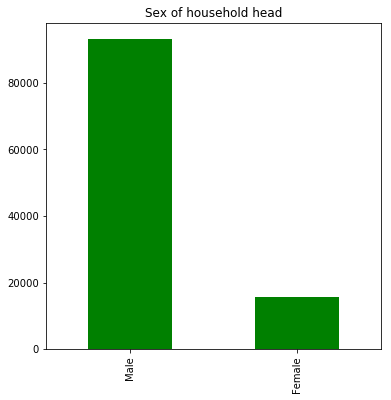

In [42]:
# plot bar graph
df2['HV219'].value_counts().plot(kind='bar', figsize=(6,6), color='g')
plt.title('Sex of household head')

### Household relationship structure

In [40]:
# value counts for HV217
df2['HV217'].value_counts()

Three+ related adults       60814
Two adults, opposite sex    35541
One adult                    8724
Two adults, same sex         2774
Unrelated adults             1069
No adults                     119
Name: HV217, dtype: int64

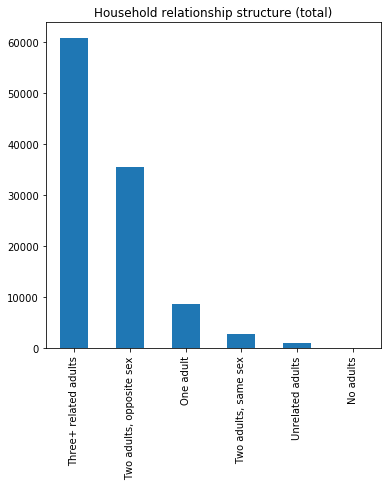

In [62]:
# plot bar graph for total HV217
df2['HV217'].value_counts().plot(kind='bar', figsize=(6,6))
plt.title('Household relationship structure (total)')

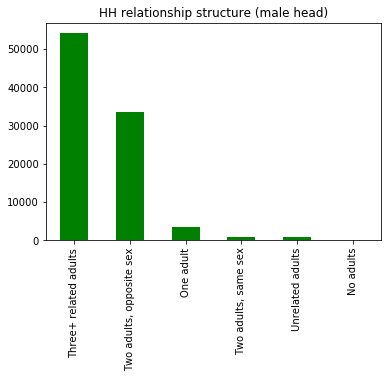

In [64]:
# plot bar graph for HV217 with male HH head
df2[df2.HV219 == 'Male']['HV217'].value_counts().plot(kind='bar', color='g')
plt.title('HH relationship structure (male head)')

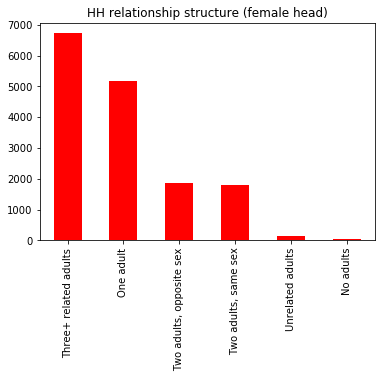

In [65]:
# plot bar graph for HV217 with female HH head
df2[df2.HV219 == 'Female']['HV217'].value_counts().plot(kind='bar', color = 'r')
plt.title('HH relationship structure (female head)')

### Comparing HV217 and HV219

In [66]:
# cross-tabulation
hh_counts = pd.crosstab(df2.HV217, df2.HV219)
hh_counts

HV219,Female,Male
HV217,,
No adults,31,88
One adult,5159,3565
Three+ related adults,6719,54095
"Two adults, opposite sex",1866,33675
"Two adults, same sex",1795,979
Unrelated adults,139,930


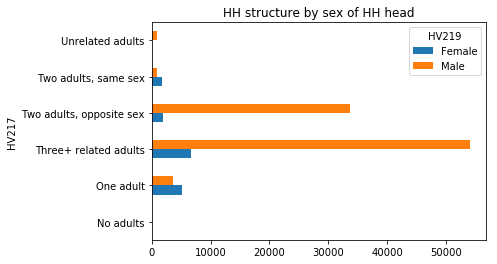

In [67]:
# plot bar graph
hh_counts.plot(kind='barh', title = 'HH structure by sex of HH head')

This is not great because the scale is different with M-head and F-head HHs.  Better to put it as a percentage...

In [68]:
# add up total male and female HH heads
total_F_heads = sum(df2['HV219'] == 'Female')
total_M_heads = sum(df2['HV219'] == 'Male')

In [70]:
# create scaled cross-tabulation
hh_counts_scaled = DataFrame()
hh_counts_scaled['Male'] = hh_counts['Male']/total_M_heads*100
hh_counts_scaled['Female'] = hh_counts['Female']/total_F_heads*100
hh_counts_scaled.columns.name = 'HV219'

hh_counts_scaled

HV219,Male,Female
HV217,,
No adults,0.094287,0.197339
One adult,3.819697,32.841047
Three+ related adults,57.959757,42.771660
"Two adults, opposite sex",36.080873,11.878541
"Two adults, same sex",1.048944,11.426571
Unrelated adults,0.996443,0.884843


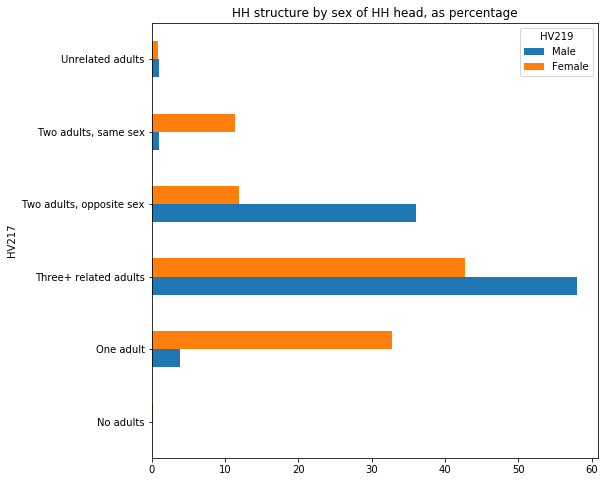

In [71]:
# bar plot of HH structure, scaled
hh_counts_scaled.plot(kind='barh', 
                      title = 'HH structure by sex of HH head, as percentage',
                     figsize = (8,8))

# `HV219` versus other variables, programmatically

Choose a categorical variable, create a staggered bar graph by HV219.

Here are some ones to try: 

In [48]:
interesting = ['HV009','HV025', 'HV026', 'HV201', 'HV202', 'HV205', 'HV206', 'HV208', 'HV212', 'HV213',
              'HV214', 'HV215', 'HV216', 'HV217', 'HV220', 'HV221', 'HV225', 'HV226', 'HV227', 'HV238',
              'HV243A', 'HV244', 'HV246', 'HV247', 'HV270', 'SH44', 'SH46', 'SH47N', 'SH58', 
              'SH62A', 'SH62F', 'SHSLI', 'SHSTRUC']

In [72]:
# dict to easily keep track of which survey questions these variables correspond to
q_dict = {'HV009':'Number of listed household members' ,
          'HV025': 'Type of place of residence', 'HV026' : 'Place of residence',
          'HV201' : 'Source of drinking water', 'HV202':'Source of non-drinking water', 
          'HV205':'Type of toilet facility', 'HV206':'Has electricity', 
          'HV208':'Has television', 'HV212':'Has car', 'HV213':'Main floor material',
          'HV214':'Main wall [exterior] material', 'HV215':'Main roof material',
          'HV216':'Rooms used for sleeping', 'HV217':'Relationship structure',
          'HV220':'Age of head of household',
          'HV221':'Has telephone (non-mobile)', 'HV225':'Shares toilet with other households',
          'HV226':'Type of cooking fuel', 'HV227':'Have bednet for sleeping',
          'HV238':'Number of households sharing toilet','HV243A': 'Has mobile telephone',
          'HV244':'Owns land usable for agriculture', 'HV246':'Livestock, herds or farm animals',
          'HV247':'Owns a bank account or post office account', 'HV270':'Wealth Index',
          'SH44':'Household head\'s religion', 'SH46':'Type of caste or tribe of the HH head',
          'SH47N':'Has computer', 'SH58':'Owns this or any other house',
          'SH62A':'Has cows/bulls/buffalo', 'SH62F':'Has chickens',
          'SHSLI':'Standard of Living Index', 'SHSTRUC':'Household structure'}

In [52]:
total_F_heads = sum(df2['HV219'] == 'Female')
total_M_heads = sum(df2['HV219'] == 'Male')

By scanning through the `interesting` string, I build code to quickly look at patterns versus `HV219`.

In [87]:
# choose a different variable string from column list
# e.g. var = 'HV217'
var = interesting[24]

In [88]:
# print variable and corresponding question
print(var + ': ' + q_dict[var])

HV270: Wealth Index


In [89]:
# look at total histogram
df2[var].value_counts()

Richest    31372
Richer     25497
Middle     20951
Poorer     16576
Poorest    14645
Name: HV270, dtype: int64

In [90]:
# check for how many NAs
df2[var].isnull().sum()

0

In [91]:
# cross-tabulate, and scale
counts = pd.crosstab(df2[var], df2['HV219'])

counts_scaled = DataFrame()
counts_scaled['Male'] = counts['Male']/total_M_heads*100
counts_scaled['Female'] = counts['Female']/total_F_heads*100
counts_scaled.columns.name = 'HV219'

In [92]:
counts_scaled

HV219,Male,Female
HV270,,
Middle,19.215275,19.205551
Poorer,15.120216,15.685276
Poorest,13.087687,15.468840
Richer,23.490336,22.744923
Richest,29.086487,26.895410


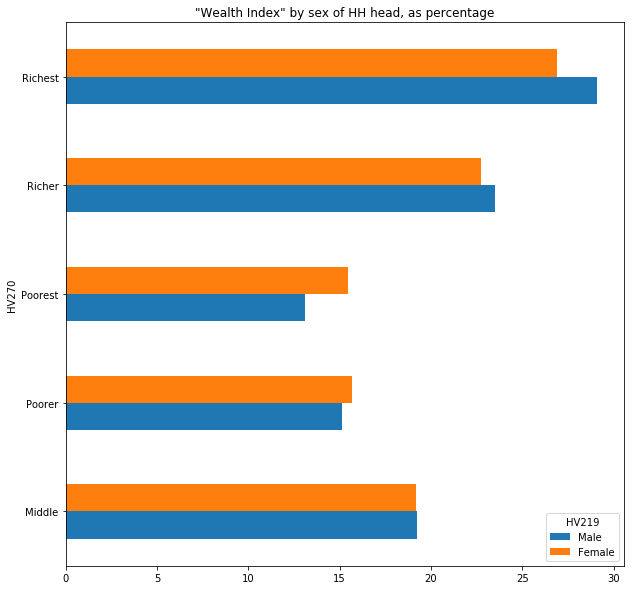

In [93]:
# generate pretty plot, and optionally saves it to file
counts_scaled.plot(kind='barh', 
                      title = '"%s" by sex of HH head, as percentage' % q_dict[var],
                     figsize = (10,10))

filename = 'versusHV219/' + var + 'byHV219.png'

# UNCOMMENT TO SAVE TO FILE
#plt.savefig(filename, dpi = 200, bbox_inches = 'tight')

In [300]:
# DO NOT EVALUATE UNLESS YOU WANT TO SAVE TO FILE
# runs through all the interesting variables and creates such plots, saves them to file
for var in interesting:
    counts = pd.crosstab(df2[var], df2['HV219'])
    counts_scaled = DataFrame()
    counts_scaled['Male'] = counts['Male']/total_M_heads*100
    counts_scaled['Female'] = counts['Female']/total_F_heads*100
    counts_scaled.columns.name = 'HV219'
    counts_scaled.plot(kind='barh', 
                      title = '"%s" by sex of HH head, as percentage' % q_dict[var],
                     figsize = (10,10))
    filename = 'versusHV219/' + var + 'byHV219.png'
    plt.savefig(filename, dpi = 200, bbox_inches = 'tight')
    plt.close()

After evaluating this code, check out the images in `versusHV219` folder to look through all these plots.

# Three main takeaways

After looking programmatically through these "interesting" mostly-categorical variables and how they compare with `HV219`, I noticed a few patterns:

1. Number of listed HH members (`HV009`) has a clear pattern: when HH has 1-3 members a female is more likely to be in charge.  When there are 4+ then a male is.  I could do more statistics with this.

2. Age of HH head (`HV220`) shows a definite difference.  Females are in charge when the HH head is older.

3. Women are more likely HH heads in a rural setting (`HV025`).  This seems broadly consistent throughout the data (e.g. `HV026`), and may explain a lot of the other tendencies: water supply, toilet, electricity, housing materials.  I split the data along the rural/urban and then look again.




### 1. Number of HH members and HV219

When the household has 1-3 members a female is more likely to be in charge. When there are 4+ then a male is.

In [103]:
# display variable for convenience
var = 'HV009'
print(var + ': ' + q_dict[var])

HV009: Number of listed household members


In [104]:
# cross-tabulate
counts = pd.crosstab(df2[var], df2['HV219'])

counts_scaled = DataFrame()
counts_scaled['Male'] = counts['Male']/total_M_heads*100
counts_scaled['Female'] = counts['Female']/total_F_heads*100
counts_scaled.columns.name = 'HV219'

In [105]:
# limit to HHs with up to 10 members, for readability
counts_scaled = counts_scaled[:10]

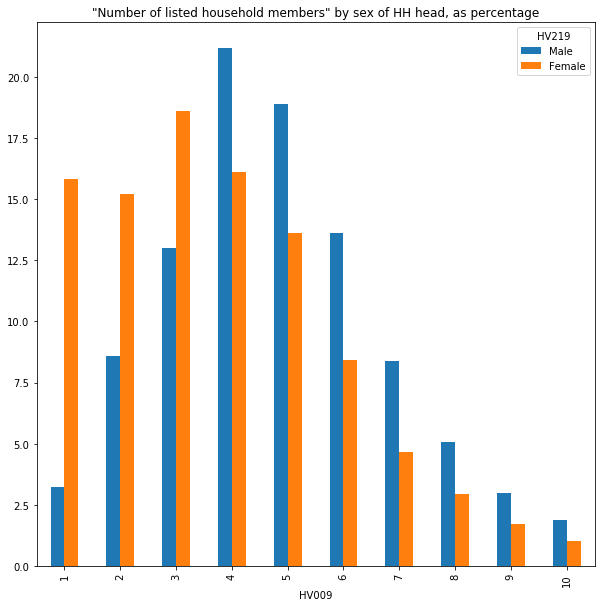

In [107]:
# bar plot
counts_scaled.plot(kind='bar', 
                      title = '"%s" by sex of HH head, as percentage' % q_dict[var],
                     figsize = (10,10))

### 2. Age of HH head and HV219

First we plot the age of the household head as a categorical variable, and then as a numeric, in both cases comparing to sex of HH head.  In general, women are in charge when the household head is older.

In [109]:
# display variable for convenience
var = 'HV220'
print(var + ': ' + q_dict[var])

HV220: Age of head of household


In [110]:
# cross-tabulate
counts = pd.crosstab(df2[var], df2['HV219'])

counts_scaled = DataFrame()
counts_scaled['Male'] = counts['Male']/total_M_heads*100
counts_scaled['Female'] = counts['Female']/total_F_heads*100
counts_scaled.columns.name = 'HV219'

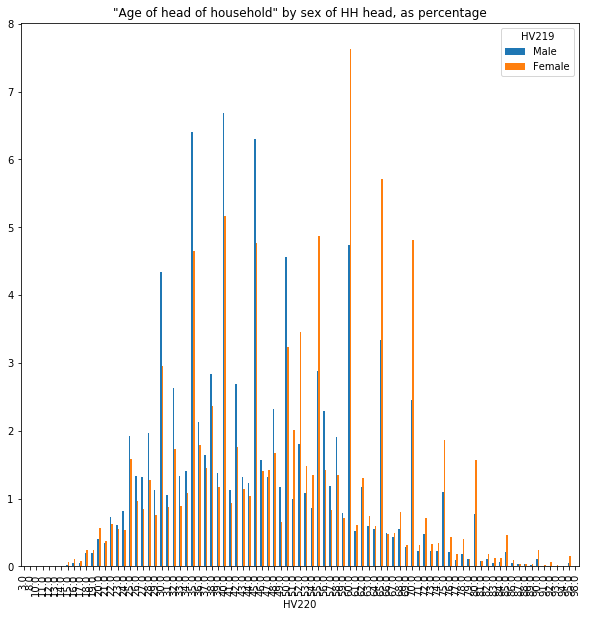

In [111]:
# bar plot, treating age as a categorical variable
counts_scaled.plot(kind='bar', 
                      title = '"%s" by sex of HH head, as percentage' % q_dict[var],
                     figsize = (10,10))

This seems to show that female HH heads tend to be older.

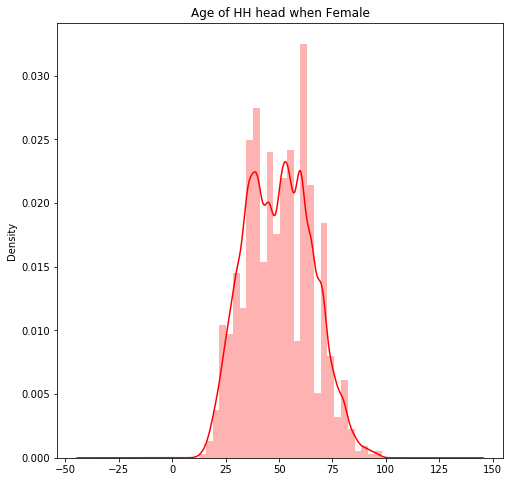

In [112]:
f_values = df2[df2.HV219 == 'Female'][var]
f_values.hist(bins=30, color = 'r', figsize=(8,8), 
              normed=True, alpha=0.3)
f_values.plot(kind='kde', style='r', title = 'Age of HH head when Female')

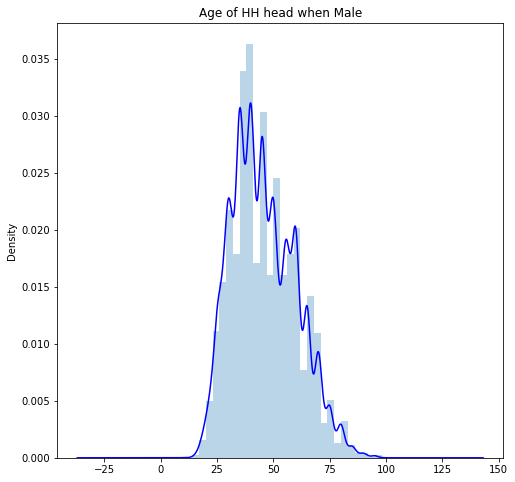

In [113]:
m_values = df2[df2.HV219 == 'Male'][var]
m_values.hist(bins=30, figsize=(8,8), normed=True, alpha=0.3)
m_values.plot(kind='kde', style='b', title = 'Age of HH head when Male')

In [351]:
plt.hist?

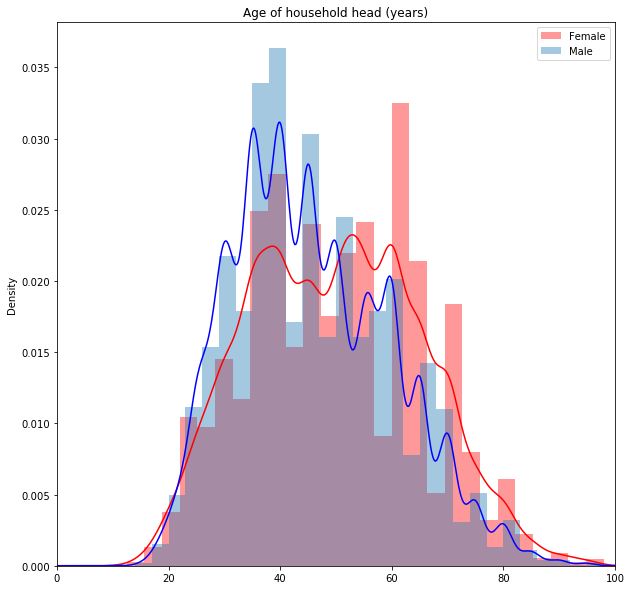

In [145]:
f_values.hist(bins=30, color = 'r', 
              normed=True, alpha=0.4, label = 'Female')
f_values.plot(kind='kde', style='r', xlim=[0,100], label='')
m_values.hist(bins=30, figsize=(10,10), normed=True, alpha=0.4, label='Male')
m_values.plot(kind='kde', style='b', xlim=[0,100], label='')
plt.title('Age of household head (years)')
plt.legend(loc='upper right')

### 3. Splitting by Rural/Urban, looking at "interesting" variables

In [373]:
# we want to look at the rural/urban variable
var = 'HV025'
print(var + ': ' + q_dict[var])

HV025: Type of place of residence


In [374]:
# about half the households are rural, half are urban
df2[var].value_counts()

Rural    58805
Urban    50236
Name: HV025, dtype: int64

In [375]:
# there are no NAs for this variable, which is nice
df2[var].isnull().sum()

0

In [382]:
df2_rural = df2[df2.HV025 == "Rural"]
df2_urban = df2[df2.HV025 == "Urban"]

In [385]:
# DO NOT EVALUATE UNLESS YOU WANT TO SAVE TO FILE
# for rural subset
# (it would be better to stack rural/urban in some way, but i don't know how to do that yet)
# runs through all the interesting variables and creates plots, saves them to file
total_F_heads = sum(df2_rural['HV219'] == 'Female')
total_M_heads = sum(df2_rural['HV219'] == 'Male')

for var in interesting:
    counts = pd.crosstab(df2_rural[var], df2_rural['HV219'])
    counts_scaled = DataFrame()
    counts_scaled['Male'] = counts['Male']/total_M_heads*100
    counts_scaled['Female'] = counts['Female']/total_F_heads*100
    counts_scaled.columns.name = 'HV219'
    counts_scaled.plot(kind='barh', 
                      title = '"%s" by sex of HH head, as percentage, in rural' % q_dict[var],
                     figsize = (10,10))
    filename = 'versusHV219/rural-urban/' + var + 'byHV219-r.png'
    plt.savefig(filename, dpi = 200, bbox_inches = 'tight')
    plt.close()

In [386]:
# DO NOT EVALUATE UNLESS YOU WANT TO SAVE TO FILE
# for urban subset
# (it would be better to stack rural/urban in some way, but i don't know how to do that yet)
# runs through all the interesting variables and creates plots, saves them to file
total_F_heads = sum(df2_urban['HV219'] == 'Female')
total_M_heads = sum(df2_urban['HV219'] == 'Male')

for var in interesting:
    counts = pd.crosstab(df2_urban[var], df2_urban['HV219'])
    counts_scaled = DataFrame()
    counts_scaled['Male'] = counts['Male']/total_M_heads*100
    counts_scaled['Female'] = counts['Female']/total_F_heads*100
    counts_scaled.columns.name = 'HV219'
    counts_scaled.plot(kind='barh', 
                      title = '"%s" by sex of HH head, as percentage, in urban' % q_dict[var],
                     figsize = (10,10))
    filename = 'versusHV219/rural-urban/' + var + 'byHV219-u.png'
    plt.savefig(filename, dpi = 200, bbox_inches = 'tight')
    plt.close()

After evaluating this code, check out the images in the `versusHV219/rural-urban` folder to look at pairs of plots.